In [153]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import skimage
import time
from sklearn.metrics import mean_absolute_error

In [176]:
# img = cv2.imread('../islands-300.jpeg')/255.0
img = cv2.imread('../Волков АК.jpg')/255.0
max_size = 1000
H, W = img.shape[0], img.shape[1]
if H > W:
    if H > max_size:
        img = cv2.resize(img, (int(W * max_size / H), max_size))
else:
    if W > max_size:
        img = cv2.resize(img, (max_size, int(H * max_size / W)))
        
H, W = img.shape[0], img.shape[1]
padding = int(W * 0.1 if H > W else H * 0.1)
zeros = np.zeros((H + padding * 2, W + padding * 2, 3))
zeros[padding: padding + H, padding: padding + W] = img
img = zeros
mask_img = np.zeros(img.shape)

blurs = dict()
for i in range(1, 100):
    blurs[i] = cv2.blur(img, (i, i))

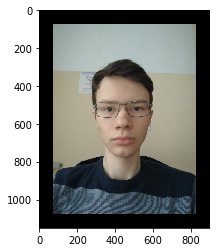

In [177]:
plt.imshow(img[:,:,::-1])

In [178]:
class Stroke():
    def __init__(self, image, dispersion, amount, speed, ttl):
        image_size = image.shape[:2]
        self.dispersion = dispersion
        x = np.random.randint(0, image_size[1], 1)
        y = np.random.randint(0, image_size[0], 1)
        self.center = np.concatenate([x, y], axis=0).astype(np.float)
        
        self.particles_angle = np.random.uniform(0, 2 * np.pi, amount)
        self.particles_radius = np.fabs(np.random.normal(0, dispersion*2, amount))
        
        self.angle = np.random.uniform(0, 2 * np.pi)
        self.rotation = np.random.uniform(-np.pi/60, np.pi/60)
        self.color = image[y[0], x[0]]
        self.speed = np.random.normal(speed, speed/3, 1)
        self.status = 'running'
        self.ttl = np.random.normal(ttl)
        self.ttl = 0.5 if self.ttl < 0.5 else self.ttl
        
        
    def get_mean_color(self, image, x, y):
        if 0 < x < image.shape[1] and 0 < y < image.shape[0]:
            return blurs[self.dispersion][int(y), int(x)]
        else:
            return self.color
        
        
    def update(self, image):  
        # add removal of some points
        self.last_center = self.center.copy()
        self.angle += self.rotation
        
        self.center[0] += np.cos(self.angle) * self.speed
        self.center[1] += np.sin(self.angle) * self.speed
        
        self.particles_angle += self.rotation
        mean_color = self.get_mean_color(image, self.center[0], self.center[1])
        self.color = self.color - (self.color - mean_color)/2
        self.ttl -= np.random.uniform(0, 0.05)
        if self.ttl <= 0:
            self.status = 'deleted'
        
        
    def draw(self, image):
        offset_x = np.cos(self.particles_angle) * self.particles_radius
        offset_y = np.sin(self.particles_angle) * self.particles_radius
        positions = (self.center.reshape(2, 1) + [offset_x, offset_y]).T.reshape(-1, 1, 2)
        last_positions = (self.last_center.reshape(2, 1) + [offset_x, offset_y]).T.reshape(-1, 1, 2)
        points = np.concatenate([last_positions, positions], axis=1).astype(np.int32)
        cv2.polylines(image, points, False, self.color, 2)   


In [179]:
print(0.1 / (1150 / 1000) ** 0.5)
print(0.1 / (350 / 1000) ** 0.5)

0.09325048082403138
0.16903085094570333


In [180]:
 0.08 * 1150

92.0

In [181]:
max_image_size = max(img.shape[:2])
max_strokes_base = int(200 * (max_image_size / 1150))
max_strokes_base = 2 if max_strokes_base < 2 else max_strokes_base
strokes_amount_base = int(10 * (max_image_size / 500))
strokes_amount_base = 1 if strokes_amount_base < 1 else strokes_amount_base
min_dispersion_base = int(10 * (max_image_size / 1150))
min_dispersion_base = 1 if min_dispersion_base < 1 else min_dispersion_base
max_dispersion_base = int(30 * (max_image_size / 1150))
max_dispersion_base = 2 if max_dispersion_base < 2 else max_dispersion_base
min_amount_base = int(50 * (max_image_size / 1150))
min_amount_base = 1 if min_amount_base < 1 else min_amount_base
max_amount_base = int(100 * (max_image_size / 1150))
max_amount_base = 2 if max_amount_base < 2 else max_amount_base
speed_base = int(10 * (max_image_size / 1150))
speed_base = 1 if speed_base < 1 else speed_base
ttl_base = int(5 * (max_image_size / 1150))
ttl_base = 1 if ttl_base < 1 else ttl_base

strokes_amount = strokes_amount_base
min_dispersion = min_dispersion_base
max_dispersion = max_dispersion_base
min_amount = min_amount_base
max_amount = max_amount_base
speed = speed_base
ttl = ttl_base

print('strokes_amount',  strokes_amount_base)
print('min_dispersion',  min_dispersion_base)
print('max_dispersion',  max_dispersion_base)
print('min_amount',  min_amount_base)
print('max_amount',  max_amount_base)
print('speed',  speed_base)
print('ttl',  ttl_base)

strokes = [Stroke(img, 
                  dispersion=np.random.randint(min_dispersion, max_dispersion), 
                  amount=np.random.randint(min_amount, max_amount),
                  speed=speed,
                  ttl=ttl) for _ in range(strokes_amount)]
total_img_value = img.sum()
error = 1
iterations = 0

# while error > (0.1 / ((max_image_size / 1000) ** 0.5)) and iterations < 5000:
while iterations < 5000:
    strokes = [st for st in strokes if st.status != 'deleted']
    for _ in range(strokes_amount - len(strokes)):
        strokes.append(Stroke(img, 
                              np.random.randint(int(min_dispersion), int(max_dispersion)), 
                              np.random.randint(int(min_amount), int(max_amount)),
                              speed=speed,
                              ttl=ttl))
        
    for st in strokes:
        st.update(img)
        st.draw(mask_img)
        
    if iterations % 200 == 0:
        error = np.abs((img - mask_img)).sum() / total_img_value
        min_dispersion = min_dispersion_base - ((min_dispersion_base - 1) * ((1 - error) ** 1))
        max_dispersion = max_dispersion_base - ((max_dispersion_base - 2) * ((1 - error) ** 1))
        min_amount = min_amount_base - ((min_amount_base - 1) * ((1 - error) ** 1))
        max_amount = max_amount_base - ((max_amount_base - 5) * ((1 - error) ** 1))
        speed = speed_base - (speed_base * 0.9 * (1 - error))
        strokes_amount = int(strokes_amount_base + (max_strokes_base - strokes_amount_base) * ((1 - error) ** 8))
        ttl = ttl_base - ((ttl_base - 1) * (1 - error))
        print(iterations, error)
        
    cv2.imshow('BlindArtist', mask_img)
    key = cv2.waitKey(1)
    if key == 27:      # esc
        break
    
    iterations += 1
        
 

strokes_amount 23
min_dispersion 10
max_dispersion 30
min_amount 50
max_amount 100
speed 10
ttl 5
0 0.9688611944865335
200 0.3355723208960801
400 0.2621271845373332
600 0.20429930587772227
800 0.15832518665479056
1000 0.12920135521077425
1200 0.10555022268418157
1400 0.09047439296693917
1600 0.07993444379120934
1800 0.07292786884619994
2000 0.06728824536772579
2200 0.0632404048862837
2400 0.059241161237343944
2600 0.0560578310848498
2800 0.054396493409521254
3000 0.05286755079915572
3200 0.051285271000090435
3400 0.049716123908544095
3600 0.0496938193589619
3800 0.048729009236265025
4000 0.048043113411447784
4200 0.04750668387760954
4400 0.047450280789882046
4600 0.04712660914588358
4800 0.047060080715702876


In [182]:
cv2.destroyAllWindows()

In [170]:
a = np.arange(0, 1, 0.01)

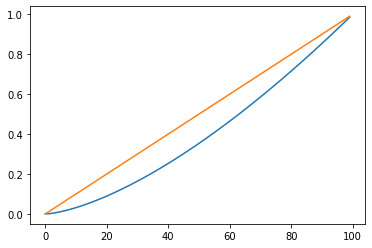

In [152]:
plt.plot(np.arange(0, 100), a**1.5)
plt.plot(np.arange(0, 100), a)